In [ ]:
!pip install Bio 

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 281.0/281.0 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 23.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.7/46.7 kB 3.0 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import math
from Bio import SeqIO
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt

# Tiền xử lý dữ liệu

Hàm chuyển đổi chuỗi peptide với 7 đặc tính sinh hóa thành 7 chiều, mỗi chiều bằng 3 thuộc tính con * (first -> 100%) = 3 * 6 = 18 ==> shape = 7, 18

Timesteps = 7, features = 18

In [ ]:
def generate_vector(sequence):
    properties = {
        "hydrophobicity": {
            "polar": "RKEDQN",
            "neutral": "GASTPHY",
            "hydrophobic": "CLVIMFW"
        },
        "vdw_volume": {
            "small": "GASTPDC",
            "medium": "NVEQIL",
            "large": "MHKFRYW"
        },
        "polarity": {
            "polar": "EDQNKR",
            "neutral": "GASTPHY",
            "nonpolar": "CLVIMFW"
        },
        "polarizability": {
            "low": "GASDT",
            "medium": "CPNVEQIL",
            "high": "KMHFRYW"
        },
        "charge": {
            "negative": "DE",
            "neutral": "ACFGHILMNPQSTVWY",
            "positive": "KR"
        },
        "secondary_structure": {
            "helix": "EALMQKRH",
            "sheet": "VIYCWT",
            "coil": "GNPSD"
        },
        "solvent_accessibility": {
            "buried": "ALFCGIVW",
            "intermediate": "MPSTHY",
            "exposed": "DEKNQR"
        }
    }

    def calculate_distribution(amino_class):
        class_residues = [i for i, aa in enumerate(sequence) if aa in amino_class]
        length = len(sequence)
        total = len(class_residues)

        if total == 0:
            return [0.0] * 6

        values = []
        for p in [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]:
            idx = math.floor(total * p)
            if idx >= total:
                idx = total - 1
            pos = class_residues[idx]
            values.append((pos + 1) / length * 100)
        return values

    matrix = []

    for prop_name in properties:
        row = []
        for class_name in properties[prop_name]:
            aa_group = properties[prop_name][class_name]
            dist = calculate_distribution(aa_group)
            row.extend(dist)  # mỗi lớp 6 mốc
        matrix.append(row)  # 3 lớp → 18 feature / 1 prop

    return np.array(matrix)  # shape (7, 18)


Thử chuyển thử chiều 1 peptide

In [ ]:
vector = generate_vector("MKKKKYLIDLFSGCGGLSFGF")
print(vector.shape)  # (7, 18)
print(vector)



















(7, 18)
[[  9.52380952  14.28571429  19.04761905  23.80952381  42.85714286
   42.85714286  28.57142857  57.14285714  61.9047619   76.19047619
   85.71428571  95.23809524   4.76190476  33.33333333  47.61904762
   66.66666667  90.47619048 100.        ]
 [ 42.85714286  57.14285714  66.66666667  71.42857143  85.71428571
   95.23809524  33.33333333  33.33333333  38.0952381   47.61904762
   80.95238095  80.95238095   4.76190476   9.52380952  19.04761905
   28.57142857  90.47619048 100.        ]
 [  9.52380952  14.28571429  19.04761905  23.80952381  42.85714286
   42.85714286  28.57142857  57.14285714  61.9047619   76.19047619
   85.71428571  95.23809524   4.76190476  33.33333333  47.61904762
   66.66666667  90.47619048 100.        ]
 [ 42.85714286  57.14285714  61.9047619   76.19047619  85.71428571
   95.23809524  33.33333333  38.0952381   47.61904762  66.66666667
   80.95238095  80.95238095   4.76190476   9.52380952  19.04761905
   28.57142857  90.47619048 100.        ]
 [ 42.85714286  42.8

Hàm đọc file fasta thành Datafrane với 3 cột ID, Lable, Sequence

In [ ]:
def fasta_to_dataframe(fasta_file):
    data = []
    for record in SeqIO.parse(fasta_file, "fasta"):
        seq_id = record.id.split()[0]
        description = record.description.split()[1]
        sequence = str(record.seq)
        data.append({
            "ID": seq_id,
            "Label": description,
            "Sequence": sequence
        })
    df = pd.DataFrame(data)
    return df

In [ ]:
df = fasta_to_dataframe('/content/DataSet_final.fasta')

In [ ]:
df['Label'] = df['Label'].map({'nAMP': 0, 'AMP': 1})
df['Label'].value_counts()

,count
Label,
0,110000
1,57796


In [ ]:
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

In [ ]:
df.head()

,ID,Label,Sequence
0,tr|A0A7C5F4W6|A0A7C5F4W6_UNCZI,0,MAREIISLACGECKRRNYATTKNKKLHPDRVEYRKFCPFCNKHTPH...
1,tr|A0A3S4FYJ7|A0A3S4FYJ7_SALET,0,MPEAYRGIGVRIEDDIVITETGNENLTAGVVKKADDIEALMAAARQQ
2,tr|A0A090RU62|A0A090RU62_9VIBR,0,MSSSDLKRLHASYHLCLYNNGTSFSRLKVDRWQDLISEK
3,WGE86681.1,1,YFQNTTKSHSFYNIATIKGY
4,tr|A0A0G0FJQ2|A0A0G0FJQ2_9BACT,0,MGTYTTYHPHKIKRKRTHGFLERMSTKGGRKVIQRRRAKGRKKLAV


In [ ]:
df.tail()

,ID,Label,Sequence
167791,tr|A0A099TA32|A0A099TA32_9RHOB,0,MIKTIMIGSTVSVQGIFVKLLPNKLMQVRVGSRIFTGRPVGAG
167792,tr|A0A076LTZ5|A0A076LTZ5_9GAMM,0,MKREFSSVNRNSPRLGKGIDHLNDEGILNEAIGKAVY
167793,tr|A0A0C1GVY3|A0A0C1GVY3_9NEIS,0,MDKMLFYNFLILNEIKFNILIKKLYYLYVLRIWLGDSTAF
167794,tr|A0A0E4BX68|A0A0E4BX68_9BRAD,0,MTNFEHDVRPTIGGEPAKLAEAQADLARAPRPERWVPKWLAEA
167795,tr|A0A0A1Z6U7|A0A0A1Z6U7_PROMR,0,MGQMDKNKKSILDFIPKEDILDFIDSDKTILEEIPKETILEELD


Chuyển các peptide về dạng 7, 18 (timesteps = 7, features = 3 * 6 = 18)

In [ ]:
X = np.array([generate_vector(seq) for seq in df["Sequence"]])  # (samples, 7, 18)
y = df["Label"].values  # (samples,)

In [ ]:
print(X.shape)
print(y.shape)

(167796, 7, 18)
(167796,)


### Chia dữ liệu trước khi chuẩn hóa, tránh bị dataleak

Chia dữ liệu thành 80% train và 20% test

In [ ]:
X_trainval, X_test, y_trainval, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

Chia 0.25% train cho val để học mô hình

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(
    X_trainval, y_trainval, test_size=0.25, random_state=42, stratify=y_trainval
)

### Chuẩn hóa dữ liệu theo MinMax scaler

In [ ]:
# MinMax scaling - chỉ fit trên train
n_steps, n_features = X.shape[1], X.shape[2]

scaler = MinMaxScaler()
X_train_flat = X_train.reshape(-1, n_features)
X_val_flat = X_val.reshape(-1, n_features)
X_test_flat = X_test.reshape(-1, n_features)

# Fit only on train
X_train_scaled = scaler.fit_transform(X_train_flat).reshape(-1, n_steps, n_features)
X_val_scaled = scaler.transform(X_val_flat).reshape(-1, n_steps, n_features)
X_test_scaled = scaler.transform(X_test_flat).reshape(-1, n_steps, n_features)

In [ ]:
model = Sequential([
    LSTM(64, input_shape=(7, 18), return_sequences=False),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 64)             │        21,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,361 (91.25 KB)

 Trainable params: 23,361 (91.25 KB)

 Non-trainable params: 0 (0.00 B)

Cơ chế dừng mô hình sau 8 epochs nếu val_loss không cải thiện, dừng và lưu mô hình tốt nhất

In [ ]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=8,
    restore_best_weights=True,
    verbose=1
)

Cơ chế giảm learning rate sau 3 epochs mà val_loss không cải thiện, nhân learning 0.5 (giảm đi một nữa)

In [ ]:
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-6,
    verbose=1
)

Huấn luyện mô hình qua 30 epochs

In [ ]:
history = model.fit(
    X_train_scaled, y_train,
    validation_data=(X_val_scaled, y_val),
    epochs=30,
    batch_size=64,
    callbacks=[early_stopping, reduce_lr],
)

Epoch 1/30
1574/1574 ━━━━━━━━━━━━━━━━━━━━ 18s 9ms/step - accuracy: 0.8894 - loss: 0.2719 - val_accuracy: 0.9540 - val_loss: 0.1495 - learning_rate: 0.0010
Epoch 2/30
1574/1574 ━━━━━━━━━━━━━━━━━━━━ 14s 9ms/step - accuracy: 0.9508 - loss: 0.1601 - val_accuracy: 0.9567 - val_loss: 0.1418 - learning_rate: 0.0010
Epoch 3/30
1574/1574 ━━━━━━━━━━━━━━━━━━━━ 13s 8ms/step - accuracy: 0.9547 - loss: 0.1514 - val_accuracy: 0.9483 - val_loss: 0.1595 - learning_rate: 0.0010
Epoch 4/30
1574/1574 ━━━━━━━━━━━━━━━━━━━━ 22s 9ms/step - accuracy: 0.9574 - loss: 0.1408 - val_accuracy: 0.9626 - val_loss: 0.1257 - learning_rate: 0.0010
Epoch 5/30
1574/1574 ━━━━━━━━━━━━━━━━━━━━ 20s 9ms/step - accuracy: 0.9597 - loss: 0.1358 - val_accuracy: 0.9649 - val_loss: 0.1201 - learning_rate: 0.0010
Epoch 6/30
1574/1574 ━━━━━━━━━━━━━━━━━━━━ 20s 9ms/step - accuracy: 0.9619 - loss: 0.1292 - val_accuracy: 0.9605 - val_loss: 0.1283 - learning_rate: 0.0010
Epoch 7/30
1574/1574 ━━━━━━━━━━━━━━━━━━━━ 14s 9ms/step - accuracy: 0.9

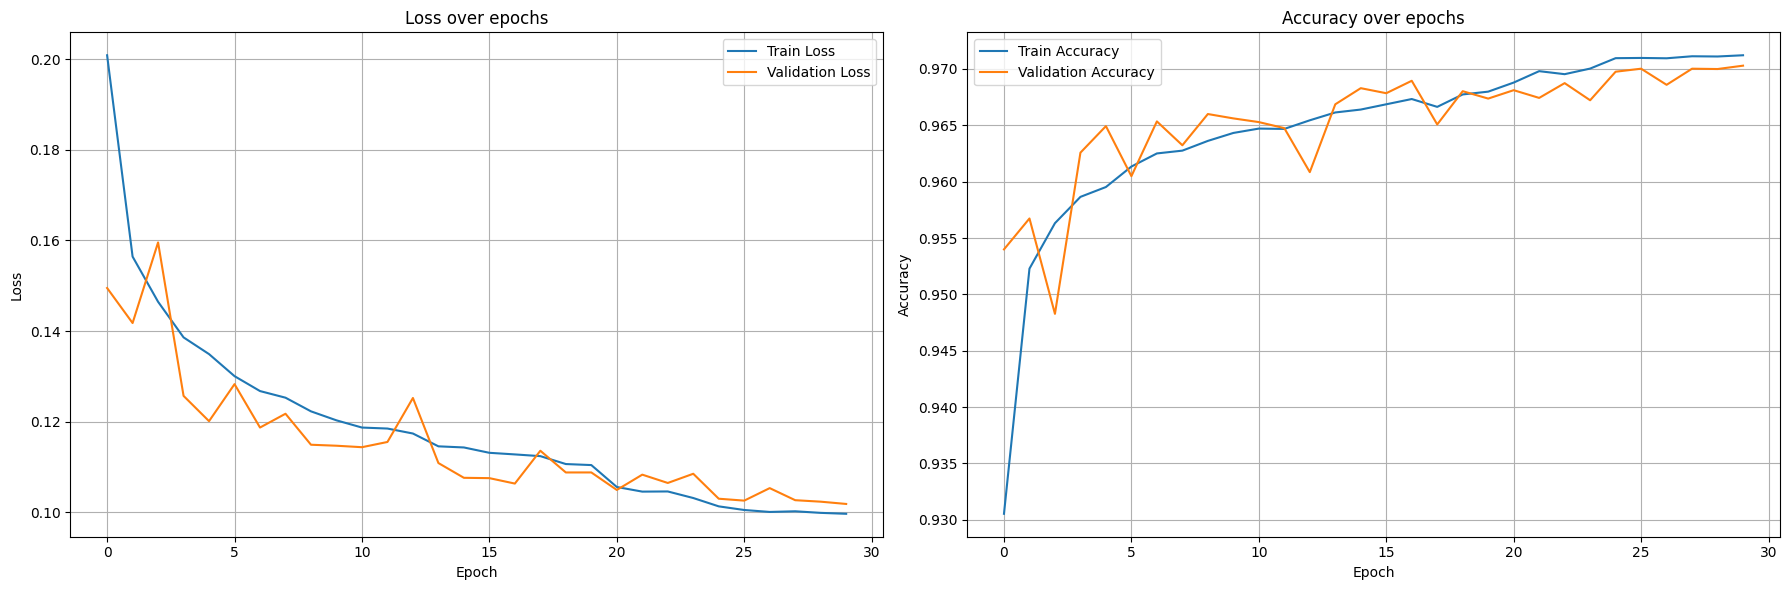

In [ ]:
def plot_history_side_by_side(history):
    fig, axs = plt.subplots(1, 2, figsize=(18, 6))

    axs[0].plot(history.history['loss'], label='Train Loss')
    axs[0].plot(history.history['val_loss'], label='Validation Loss')
    axs[0].set_title('Loss over epochs')
    axs[0].set_xlabel('Epoch')
    axs[0].set_ylabel('Loss')
    axs[0].legend()
    axs[0].grid(True)

    axs[1].plot(history.history['accuracy'], label='Train Accuracy')
    axs[1].plot(history.history['val_accuracy'], label='Validation Accuracy')
    axs[1].set_title('Accuracy over epochs')
    axs[1].set_xlabel('Epoch')
    axs[1].set_ylabel('Accuracy')
    axs[1].legend()
    axs[1].grid(True)

    plt.tight_layout()
    plt.show()

plot_history_side_by_side(history)


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

y_pred = (model.predict(X_test_scaled) > 0.5).astype("int32")
print(classification_report(y_test, y_pred))


1049/1049 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step
              precision    recall  f1-score   support

           0       0.97      0.98      0.98     22001
           1       0.96      0.95      0.95     11559

    accuracy                           0.97     33560
   macro avg       0.97      0.96      0.96     33560
weighted avg       0.97      0.97      0.97     33560



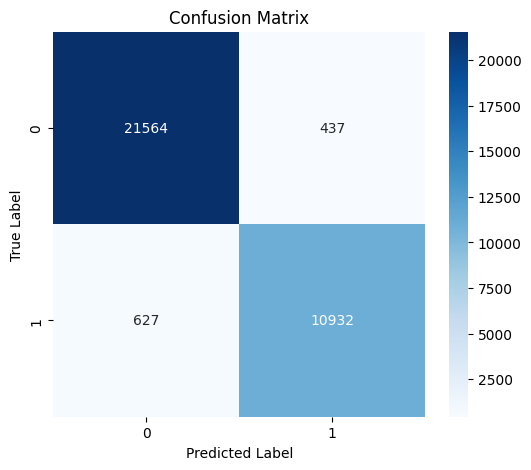

In [ ]:
import seaborn as sns
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

## Salicency XAI

In [ ]:
!pip install tf-keras-vis

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.5/52.5 kB 3.0 MB/s eta 0:00:00


In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
def compute_saliency(model, input_tensor):
    input_tensor = tf.convert_to_tensor(input_tensor)
    input_tensor = tf.cast(input_tensor, tf.float32)
    input_tensor = tf.Variable(input_tensor)

    with tf.GradientTape() as tape:
        tape.watch(input_tensor)
        prediction = model(input_tensor)
        loss = prediction[:, 0]

    grads = tape.gradient(loss, input_tensor)
    return grads.numpy()

In [ ]:
sample = X_test_scaled[0:1]
saliency_map = compute_saliency(model, sample)
mean_saliency = np.mean(np.abs(saliency_map[0]), axis=1)

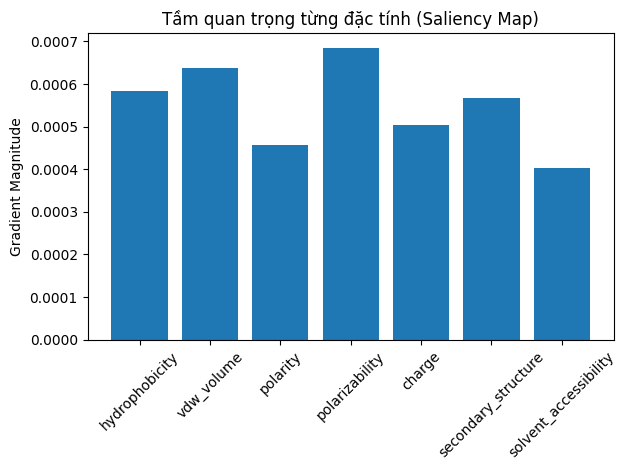

In [ ]:
plt.bar(range(7), mean_saliency)
plt.xticks(range(7), [
    'hydrophobicity', 'vdw_volume', 'polarity',
    'polarizability', 'charge', 'secondary_structure', 'solvent_accessibility'
], rotation=45)
plt.ylabel("Gradient Magnitude")
plt.title("Tầm quan trọng từng đặc tính (Saliency Map)")
plt.tight_layout()
plt.show()


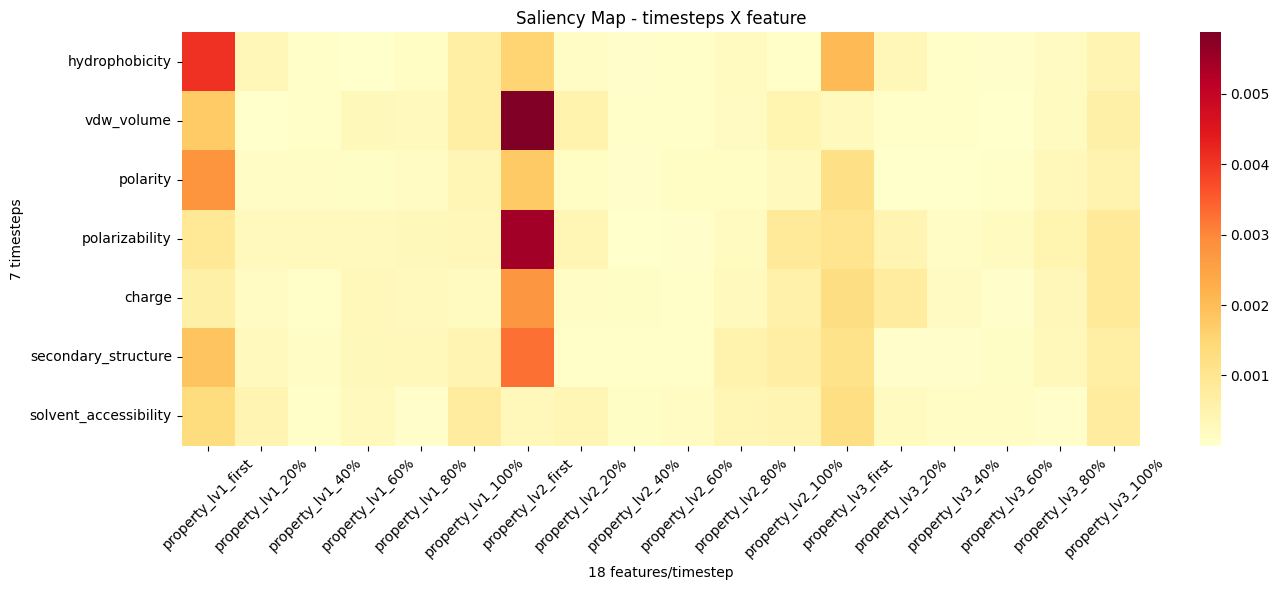

In [ ]:
sample_saliency = np.abs(saliency_map[0])

timestep_labels = [
    'hydrophobicity', 'vdw_volume', 'polarity',
    'polarizability', 'charge', 'secondary_structure', 'solvent_accessibility'
]
feature_labels = []
subclasses = ['property_lv1', 'property_lv2', 'property_lv3']
percentiles = ['first', '20%', '40%', '60%', '80%', '100%']
for sub in subclasses:
    for pct in percentiles:
        feature_labels.append(f"{sub}_{pct}")
plt.figure(figsize=(14, 6))
sns.heatmap(sample_saliency, annot=False, cmap="YlOrRd", xticklabels=feature_labels, yticklabels=timestep_labels)
plt.title("Saliency Map - timesteps X feature")
plt.xlabel("18 features/timestep")
plt.ylabel("7 timesteps")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Ở bước chiều vdw_volume với đặc trưng property_lv1_100% (vdw_volume_small_100%) đang được Saliency cho là đặc trưng đóng góp tốt nhất

### XAI WITH INTEGRATED GRADIENTS

In [ ]:
import tensorflow as tf
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
def compute_integrated_gradients(model, input_tensor, baseline=None, steps=50):
    input_tensor = tf.cast(input_tensor, tf.float32)

    if baseline is None:
        baseline = tf.zeros_like(input_tensor)

    interpolated_inputs = [
        baseline + (float(i) / steps) * (input_tensor - baseline)
        for i in range(steps + 1)
    ]
    interpolated_inputs = tf.convert_to_tensor(np.concatenate(interpolated_inputs, axis=0))

    with tf.GradientTape() as tape:
        tape.watch(interpolated_inputs)
        predictions = model(interpolated_inputs)
        target = predictions[:, 0]

    grads = tape.gradient(target, interpolated_inputs)
    avg_grads = tf.reduce_mean(grads, axis=0, keepdims=True)

    ig = (input_tensor - baseline) * avg_grads
    return ig.numpy()


In [ ]:
sample = X_test_scaled[0:1]
ig_map = compute_integrated_gradients(model, sample, steps=50)

In [ ]:
mean_ig = np.mean(np.abs(ig_map[0]), axis=1)

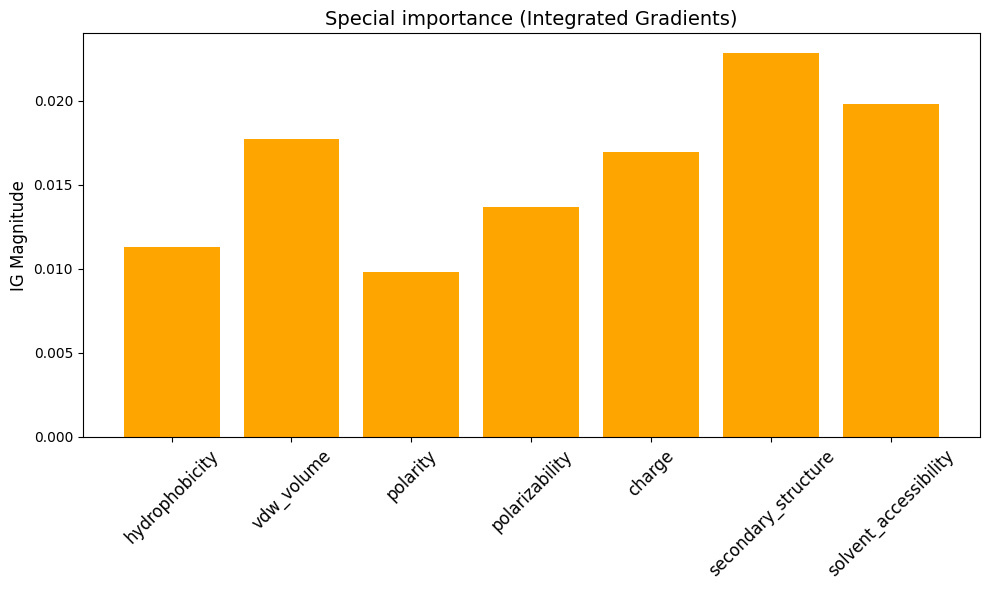

In [ ]:
plt.figure(figsize=(10, 6))
plt.bar(
    range(7),
    mean_ig,
    color="orange"
)
plt.xticks(
    range(7),
    [
        'hydrophobicity', 'vdw_volume', 'polarity',
        'polarizability', 'charge', 'secondary_structure', 'solvent_accessibility'
    ],
    rotation=45,
    fontsize=12
)
plt.title("Special importance (Integrated Gradients)", fontsize=14)
plt.ylabel("IG Magnitude", fontsize=12)
plt.tight_layout()
plt.show()


In [ ]:
sample = X_test_scaled[0:1]
ig_map = compute_integrated_gradients(model, sample, steps=50)

In [ ]:
ig_detail = np.abs(ig_map[0])

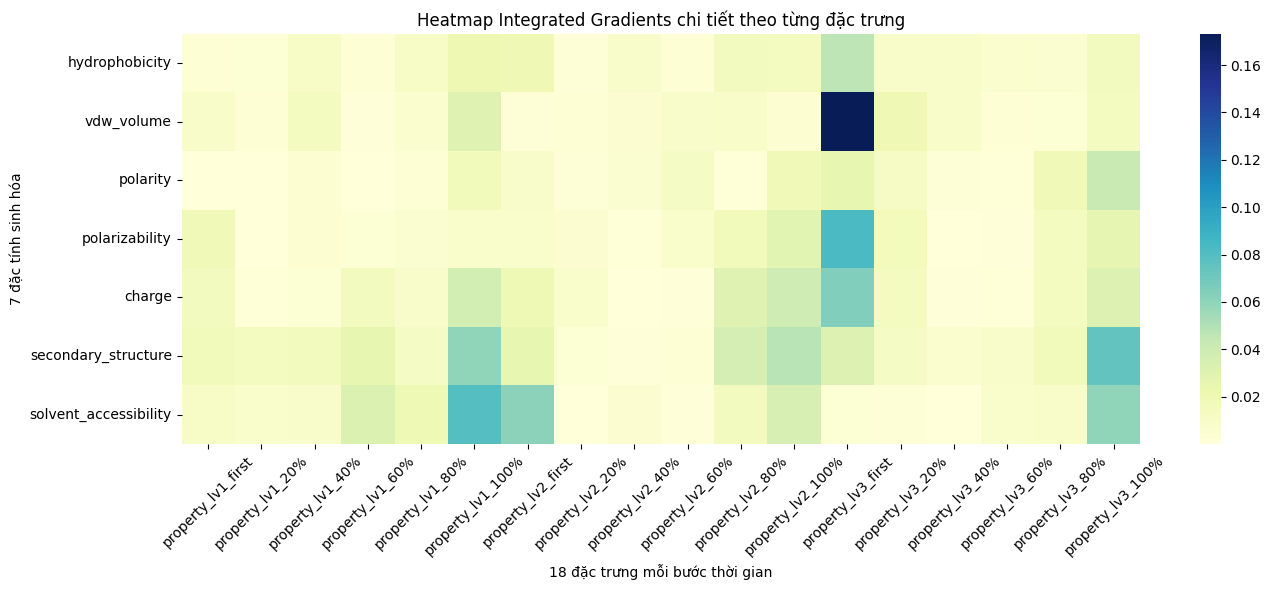

In [ ]:
timestep_labels = [
    'hydrophobicity', 'vdw_volume', 'polarity',
    'polarizability', 'charge', 'secondary_structure', 'solvent_accessibility'
]

feature_labels = []
subclasses = ['property_lv1', 'property_lv2', 'property_lv3']
percentiles = ['first', '20%', '40%', '60%', '80%', '100%']
for sub in subclasses:
    for pct in percentiles:
        feature_labels.append(f"{sub}_{pct}")

plt.figure(figsize=(14, 6))
sns.heatmap(ig_detail, annot=False, cmap="YlGnBu", xticklabels=feature_labels, yticklabels=timestep_labels)
plt.title("Heatmap Integrated Gradients chi tiết theo từng đặc trưng")
plt.xlabel("18 đặc trưng mỗi bước thời gian")
plt.ylabel("7 đặc tính sinh hóa")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


## XAI with LIME

In [ ]:
!pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 9.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=b81a92ad831897fb69d821933f43c2c470c8a916826c4db96faa326eab8608ed
  Stored in directory: /root/.cache/pip/wheels/85/fa/a3/9c2d44c9f3cd77cf4e533b58900b2bf4487f2a17e8ec212a3d
Successfully built lime


In [ ]:
X_train_flat = X_train.reshape(X_train.shape[0], -1)  # (samples, 126)
X_test_flat = X_test.reshape(X_test.shape[0], -1)

In [ ]:
feature_names = [f't{t}_f{f}' for t in range(7) for f in range(18)]

In [ ]:
from lime.lime_tabular import LimeTabularExplainer

explainer = LimeTabularExplainer(
    training_data=X_train_flat,
    mode='classification',
    feature_names=feature_names,
    class_names=['non-AMP', 'AMP'],
    discretize_continuous=True
)


In [ ]:
def predict_fn(X_flat):
    X_reshaped = X_flat.reshape(-1, 7, 18)
    preds = model.predict(X_reshaped)
    return np.hstack([(1 - preds), preds])  # LIME cần xác suất từng class


In [ ]:
i = 3  # sample index trong X_test
exp = explainer.explain_instance(
    X_test_flat[i],
    predict_fn,
    num_features=10
)


157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


In [ ]:
exp.show_in_notebook(show_table=True)